# Health Economics with R

This notebook demonstrates core methods in **Health Economics** and **Pharmacoeconomics**:

1. Cost‑effectiveness & ICER  
2. QALYs (Quality Adjusted Life Years)  
3. Decision Trees  
4. Markov Models for chronic disease  
5. Probabilistic Sensitivity Analysis (PSA: CEAC, EVPI)  
6. Budget Impact Analysis (BIA)  
7. Survival & Health Outcomes modeling  

This is a **teaching portfolio**: every part has **R code** + **explanation**.

In [1]:
# Install and load packages (if not already available)
install.packages(c("ggplot2","dplyr","heemod","reshape2"))

library(ggplot2)
library(dplyr)
library(heemod)   # for health economic modeling
library(reshape2)

# Example dataset: 100 patients, cost and effect
set.seed(123)
data <- data.frame(
  patient = 1:100,
  cost_A = rnorm(100, mean=5000, sd=800),
  eff_A = rnorm(100, mean=7, sd=1),
  cost_B = rnorm(100, mean=6000, sd=900),
  eff_B = rnorm(100, mean=8, sd=1)
)
head(data)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘RcppArmadillo’, ‘BH’, ‘mvnfast’, ‘plyr’



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




,patient,cost_A,eff_A,cost_B,eff_B
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,4551.619,6.289593,7978.929,7.284758
2,2,4815.858,7.256884,7181.172,7.247311
3,3,6246.967,6.753308,5761.369,7.061461
4,4,5056.407,6.652457,6488.875,6.947487
5,5,5103.430,6.048381,5627.094,7.562840
6,6,6372.052,6.954972,5571.378,8.331179


In [2]:
# Mean costs and effects
summary_df <- data %>%
  summarise(
    mean_cost_A = mean(cost_A),
    mean_eff_A = mean(eff_A),
    mean_cost_B = mean(cost_B),
    mean_eff_B = mean(eff_B)
  )

summary_df

mean_cost_A,mean_eff_A,mean_cost_B,mean_eff_B
<dbl>,<dbl>,<dbl>,<dbl>
5072.325,6.892453,6108.419,7.963777


In [3]:
icer <- (summary_df$mean_cost_B - summary_df$mean_cost_A) /
        (summary_df$mean_eff_B - summary_df$mean_eff_A)

icer

[1] 967.1154

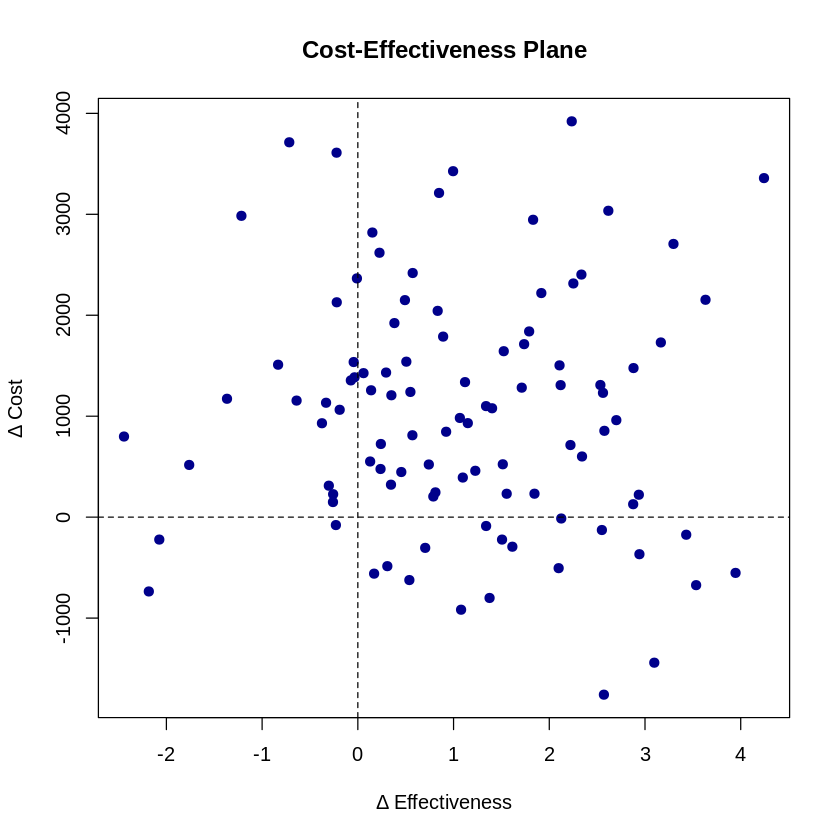

In [4]:
delta_cost <- data$cost_B - data$cost_A
delta_eff  <- data$eff_B - data$eff_A

plot(delta_eff, delta_cost,
     xlab="Δ Effectiveness",
     ylab="Δ Cost",
     main="Cost-Effectiveness Plane",
     col="darkblue", pch=19)
abline(h=0, v=0, lty=2)

In [9]:
# Simulate simple patient data
set.seed(123)
patients <- data.frame(
  patient = 1:50,
  life_years = runif(50, 5, 15),
  utility = runif(50, 0.6, 1)  # quality weight between 0.6–1
)

# Calculate QALYs
patients$QALY <- patients$life_years * patients$utility

mean_qaly <- mean(patients$QALY)
mean_qaly

[1] 8.092023

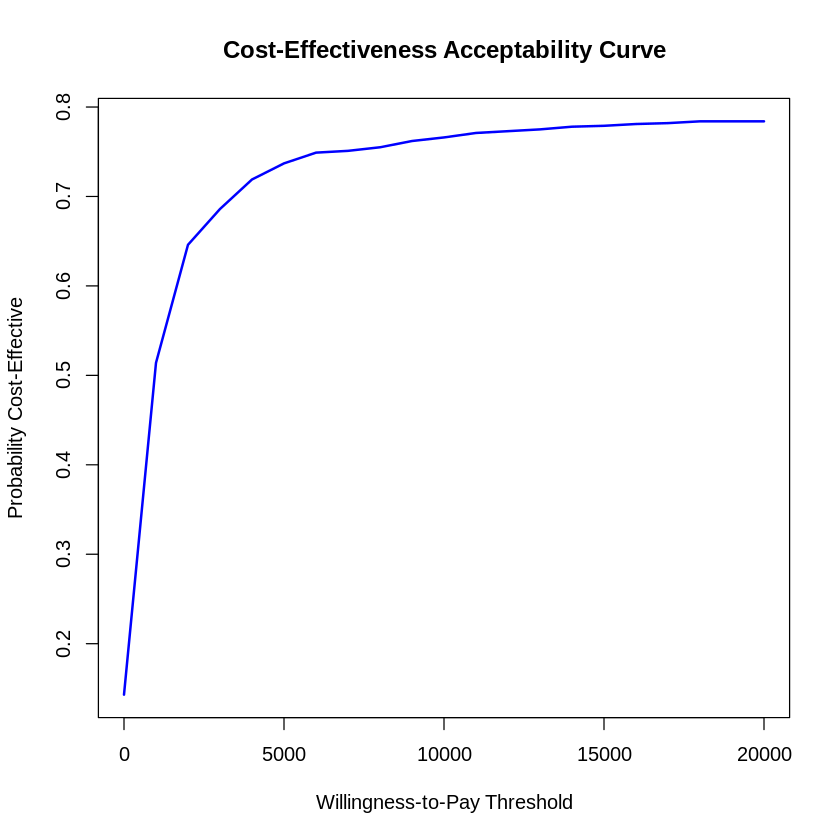

In [10]:
# Simulate uncertainty distributions: costs & effects for two treatments
n_sim <- 1000
cost_A <- rnorm(n_sim, mean=5000, sd=600)
eff_A  <- rnorm(n_sim, mean=7, sd=0.8)
cost_B <- rnorm(n_sim, mean=6000, sd=700)
eff_B  <- rnorm(n_sim, mean=8, sd=0.9)

# Incrementals
delta_cost <- cost_B - cost_A
delta_eff  <- eff_B - eff_A

icer_values <- delta_cost / delta_eff

# Cost-effectiveness acceptability curve (CEAC)
thresholds <- seq(0, 20000, 1000)
ceac <- sapply(thresholds, function(lam) mean((delta_cost - lam*delta_eff) < 0))

plot(thresholds, ceac, type='l', col='blue', lwd=2,
     xlab="Willingness-to-Pay Threshold", ylab="Probability Cost-Effective",
     main="Cost-Effectiveness Acceptability Curve")

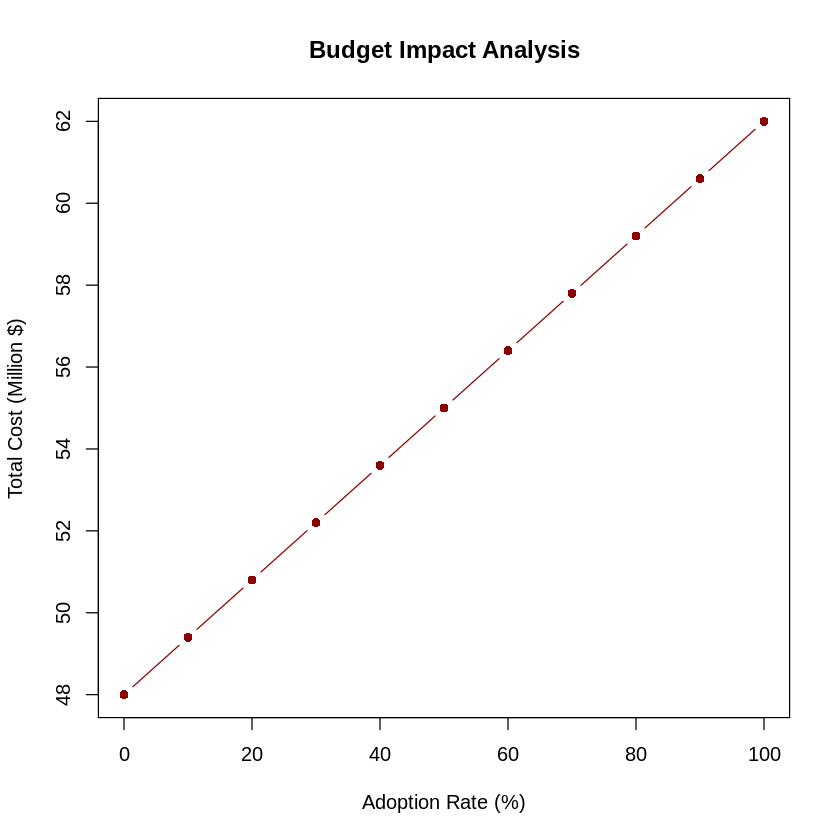

In [11]:
# Example: 10,000 patients → adoption of new drug
n_patients <- 10000
cost_current <- 4800
cost_new     <- 6200

adoption_rate <- seq(0, 1, 0.1)  # from 0% to 100%
total_costs <- (n_patients * cost_current * (1 - adoption_rate)) +
               (n_patients * cost_new * adoption_rate)

plot(adoption_rate*100, total_costs/1e6, type="b", pch=16, col="darkred",
     xlab="Adoption Rate (%)", ylab="Total Cost (Million $)",
     main="Budget Impact Analysis")

In [12]:
# Install needed packages
install.packages(c("ggplot2","dplyr","reshape2","heemod","survival"))

# Load libraries
library(ggplot2)
library(dplyr)
library(reshape2)
library(heemod)
library(survival)

# Example dataset: treatment A vs treatment B
set.seed(123)
data <- data.frame(
  patient = 1:100,
  cost_A = rnorm(100, mean=5000, sd=800),
  eff_A = rnorm(100, mean=7, sd=1),
  cost_B = rnorm(100, mean=6000, sd=900),
  eff_B = rnorm(100, mean=8, sd=1)
)

head(data, 10)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



,patient,cost_A,eff_A,cost_B,eff_B
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,4551.619,6.289593,7978.929,7.284758
2,2,4815.858,7.256884,7181.172,7.247311
3,3,6246.967,6.753308,5761.369,7.061461
4,4,5056.407,6.652457,6488.875,6.947487
5,5,5103.430,6.048381,5627.094,7.562840
6,6,6372.052,6.954972,5571.378,8.331179
7,7,5368.733,6.215096,5290.257,5.985790
8,8,3987.951,5.332058,5464.844,8.211980
9,9,4450.518,6.619773,7485.817,9.236675


## Section 2 — Cost‑Effectiveness Basics

We want to evaluate whether **Treatment B** is more cost‑effective than **Treatment A**.

1. Compute mean **costs** and **effects** (e.g. life‑years) per group.  
2. Compare incremental cost and effectiveness.  
3. Calculate the **ICER** (Incremental Cost‑Effectiveness Ratio).  
4. Visualize on the **Cost‑Effectiveness Plane**.

  mean_cost_A mean_eff_A mean_cost_B mean_eff_B
1    5072.325   6.892453    6108.419   7.963777
Incremental Cost-Effectiveness Ratio (ICER): 967.1154 


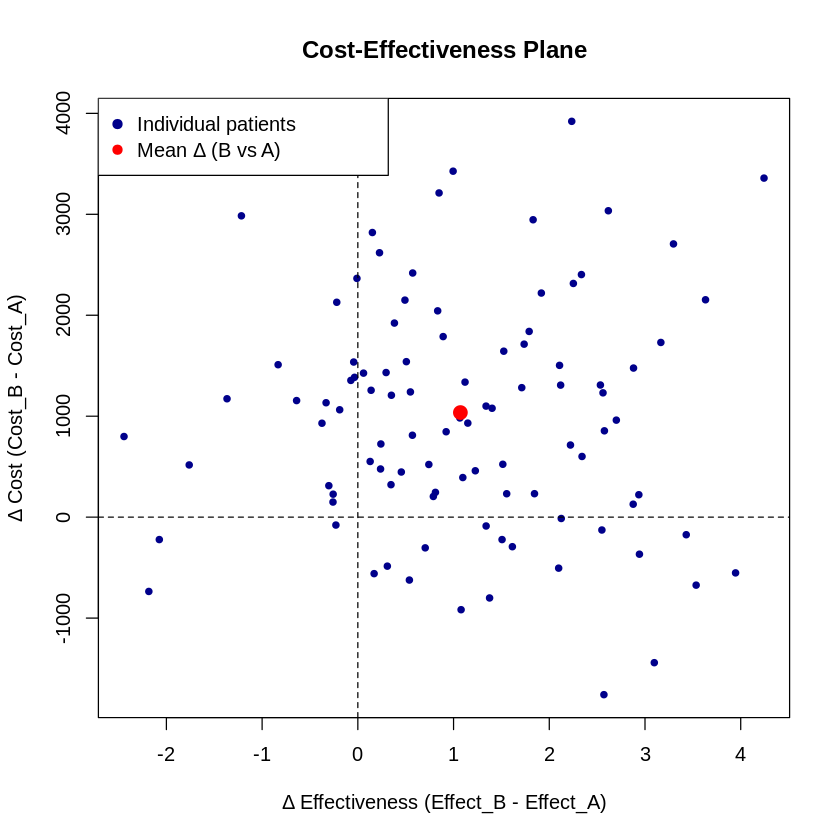

In [13]:
# Step 1: Mean cost and effect by treatment
summary_df <- data %>%
  summarise(
    mean_cost_A = mean(cost_A),
    mean_eff_A  = mean(eff_A),
    mean_cost_B = mean(cost_B),
    mean_eff_B  = mean(eff_B)
  )

print(summary_df)

# Step 2: Incremental values
delta_cost <- summary_df$mean_cost_B - summary_df$mean_cost_A
delta_eff  <- summary_df$mean_eff_B - summary_df$mean_eff_A

# Step 3: ICER calculation
icer <- delta_cost / delta_eff
cat("Incremental Cost-Effectiveness Ratio (ICER):", icer, "\n")

# Step 4: Visualize the Cost-Effectiveness Plane
points_df <- data.frame(
  delta_cost = data$cost_B - data$cost_A,
  delta_eff  = data$eff_B - data$eff_A
)

plot(points_df$delta_eff, points_df$delta_cost,
     xlab="Δ Effectiveness (Effect_B - Effect_A)",
     ylab="Δ Cost (Cost_B - Cost_A)",
     main="Cost-Effectiveness Plane",
     col="darkblue", pch=19, cex=0.7)
abline(h=0, v=0, lty=2)

# Plot the average incremental result
points(mean(points_df$delta_eff), mean(points_df$delta_cost),
       pch=19, col="red", cex=1.5)
legend("topleft", legend=c("Individual patients","Mean Δ (B vs A)"),
       col=c("darkblue","red"), pch=c(19,19))

## Section 3 — Quality‑Adjusted Life Years (QALYs)

- **Life Years (LY):** number of years lived.  
- **Utility Weight (0–1):** quality of health in that period.  
- **QALY = Life Years × Utility.**

This allows us to capture *both* quantity and quality of life.  
We’ll simulate patient utility weights and calculate QALYs for Treatments A and B.

  mean_QALY_A mean_QALY_B
1    5.513195    6.413995
Incremental QALY (B vs A): 0.9008003 


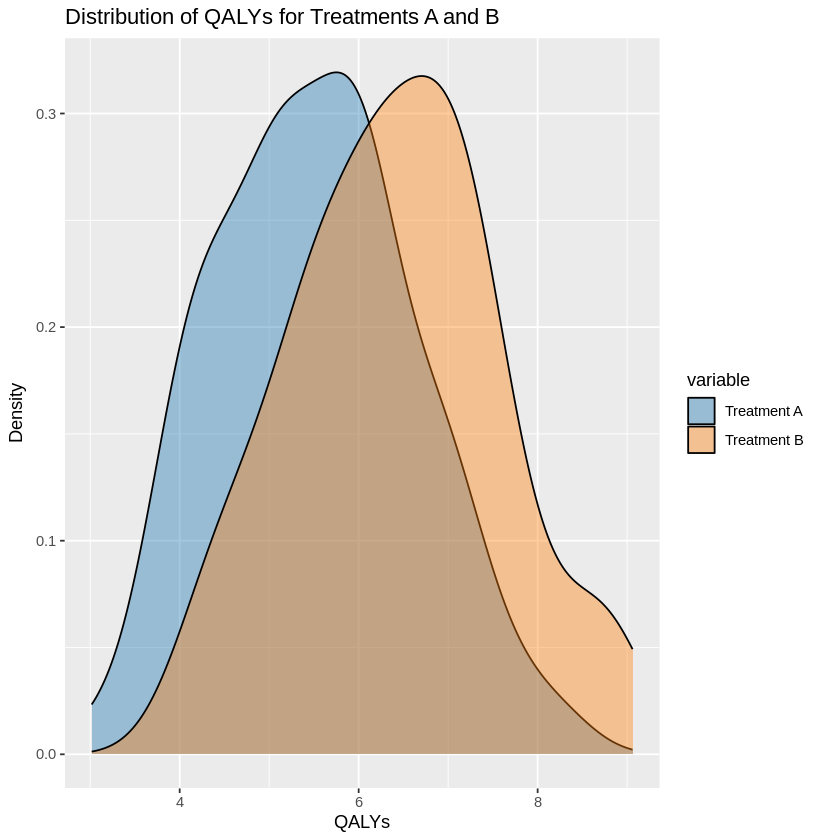

In [14]:
# Simulate utility weights (quality between 0.6 and 1)
set.seed(123)
data$utility_A <- runif(100, 0.6, 1.0)
data$utility_B <- runif(100, 0.6, 1.0)

# Calculate QALYs = LY * Utility
data$QALY_A <- data$eff_A * data$utility_A
data$QALY_B <- data$eff_B * data$utility_B

# Mean QALY per treatment
qaly_summary <- data %>%
  summarise(
    mean_QALY_A = mean(QALY_A),
    mean_QALY_B = mean(QALY_B)
  )

print(qaly_summary)

# Incremental QALY
delta_qaly <- qaly_summary$mean_QALY_B - qaly_summary$mean_QALY_A
cat("Incremental QALY (B vs A):", delta_qaly, "\n")

# Plot distribution of QALYs
qaly_melt <- melt(data[,c("patient","QALY_A","QALY_B")], id.vars="patient")

ggplot(qaly_melt, aes(x=value, fill=variable)) +
  geom_density(alpha=0.4) +
  labs(title="Distribution of QALYs for Treatments A and B",
       x="QALYs", y="Density") +
  scale_fill_manual(values=c("#1f77b4","#ff7f0e"),
                    labels=c("Treatment A","Treatment B"))

## Section 4 — Decision Trees

Decision trees are widely used in **short‑term health economic evaluation**.  
They allow modelling of **different clinical pathways** from a choice point.  

Example:  
- Strategy A: Standard treatment  
- Strategy B: New treatment  

Each has probabilities of outcomes:
- Success  
- Failure  
- Complication  

We assign **costs** and **utilities (QALYs)** to each outcome, then compute the **expected value** for each strategy.

In [15]:
# Example: Two strategies with branches
# Probabilities must sum to 1 per strategy

tree <- data.frame(
  strategy = c("A","A","B","B"),
  outcome  = c("success","failure","success","failure"),
  prob     = c(0.7, 0.3, 0.85, 0.15),
  cost     = c(4000, 2000, 6000, 2500),
  qaly     = c(8,      4,     9,      6)
)

tree

# --- Expected Cost & QALY per strategy ---
exp_values <- tree %>%
  group_by(strategy) %>%
  summarise(
    exp_cost = sum(prob * cost),
    exp_qaly = sum(prob * qaly)
  )

exp_values

# --- Incremental values & ICER ---
delta_cost <- exp_values$exp_cost[exp_values$strategy=="B"] -
              exp_values$exp_cost[exp_values$strategy=="A"]

delta_qaly <- exp_values$exp_qaly[exp_values$strategy=="B"] -
              exp_values$exp_qaly[exp_values$strategy=="A"]

icer_tree <- delta_cost / delta_qaly

cat("Decision Tree ICER (B vs A):", icer_tree, "\n")

strategy,outcome,prob,cost,qaly
<chr>,<chr>,<dbl>,<dbl>,<dbl>
A,success,0.70,4000,8
A,failure,0.30,2000,4
B,success,0.85,6000,9
B,failure,0.15,2500,6


strategy,exp_cost,exp_qaly
<chr>,<dbl>,<dbl>
A,3400,6.80
B,5475,8.55


Decision Tree ICER (B vs A): 1185.714 


## Section 5 — Markov Models

Decision trees become *too big* when we simulate **chronic diseases** (many cycles).  
Instead, we use **Markov models** with:

- **States** (e.g., Healthy, Sick, Dead)  
- **Transition probabilities** (chance of moving from one state to another per cycle)  
- **Rewards** (costs & utilities per state per cycle)  

We can simulate over multiple years → accumulating costs and QALYs.

## Section 6 — Probabilistic Sensitivity Analysis (PSA)

In the real world, **costs and effects are uncertain**.
PSA accounts for parameter uncertainty by:

1. Specifying probability distributions for input parameters  
   - Costs (e.g., Gamma distribution)  
   - Effects / QALYs (e.g., Normal or Beta distribution)  

2. Running **many simulations** (Monte Carlo).  

3. Generating outputs:
   - Cost‑Effectiveness Acceptability Curve (CEAC)  
   - Expected Value of Perfect Information (EVPI)  

These help answer:  
- "How much confidence do we have that a new treatment is cost‑effective?"  
- "Is it worth funding more research?"

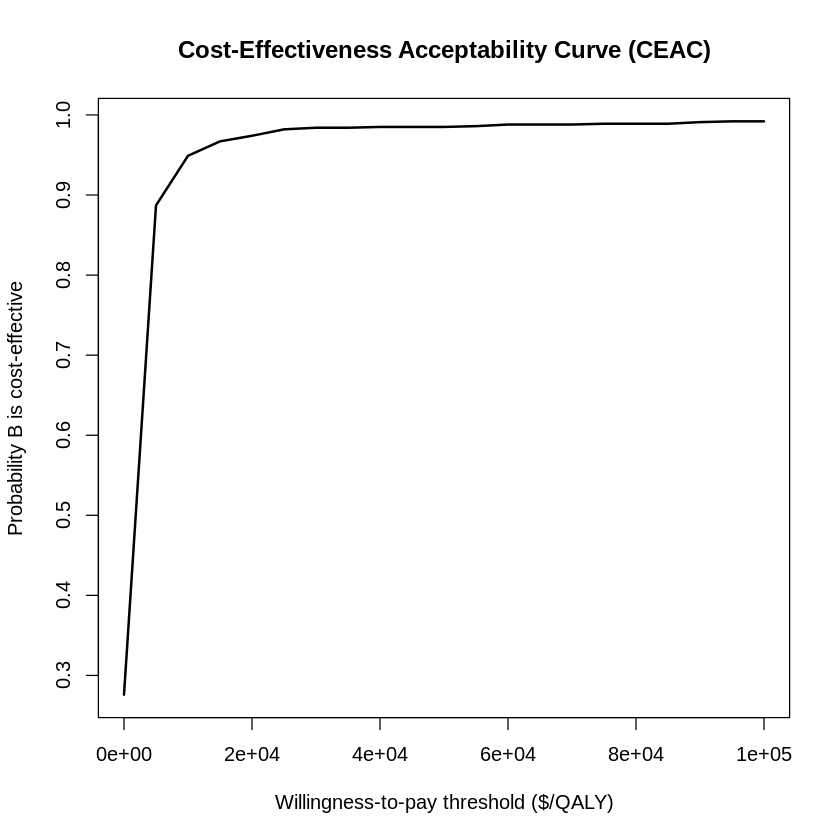

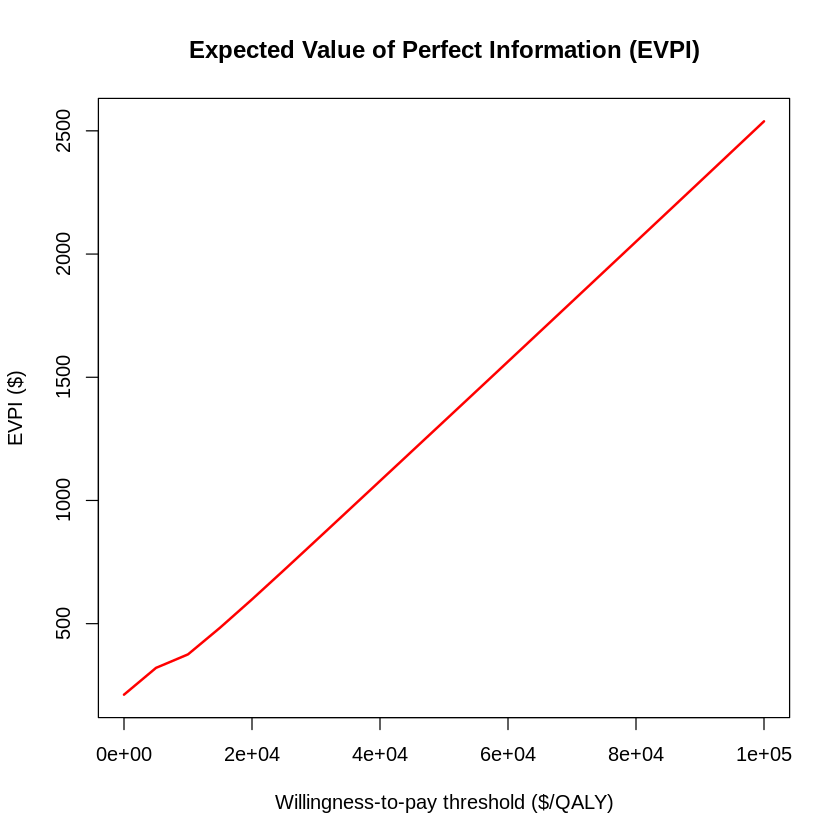

In [21]:
set.seed(123)

# Number of simulations
n_sim <- 1000

# Simulate uncertain parameters
# Assume Treatment A: lower cost, lower effect
# Assume Treatment B: higher cost, higher effect
cost_A <- rgamma(n_sim, shape=25, scale=200)   # mean 5000
qaly_A <- rnorm(n_sim, mean=7, sd=0.5)

cost_B <- rgamma(n_sim, shape=30, scale=200)   # mean 6000
qaly_B <- rnorm(n_sim, mean=8, sd=0.5)

# Incremental costs and QALYs
delta_cost <- cost_B - cost_A
delta_qaly <- qaly_B - qaly_A

# Willingness-to-pay thresholds
wtp <- seq(0, 100000, by=5000)

# Probability B is cost-effective at each WTP
ce_prob <- sapply(wtp, function(w) {
  mean((delta_cost/delta_qaly) < w)
})

# CEAC Plot
plot(wtp, ce_prob, type="l", lwd=2,
     xlab="Willingness-to-pay threshold ($/QALY)",
     ylab="Probability B is cost-effective",
     main="Cost-Effectiveness Acceptability Curve (CEAC)")

# --- EVPI ---
# Net monetary benefit for each sim at each WTP
nmb_A <- sapply(wtp, function(w) qaly_A*w - cost_A)
nmb_B <- sapply(wtp, function(w) qaly_B*w - cost_B)

# Decision uncertainty (value of perfect info)
evpi <- colMeans(pmax(nmb_A, nmb_B)) - pmax(colMeans(nmb_A), colMeans(nmb_B))

# EVPI Plot
plot(wtp, evpi, type="l", lwd=2, col="red",
     xlab="Willingness-to-pay threshold ($/QALY)",
     ylab="EVPI ($)",
     main="Expected Value of Perfect Information (EVPI)")

## Section 7 — Budget Impact Analysis (BIA)

While cost-effectiveness asks **"is it worth it?"**,  
Budget Impact Analysis asks **"can we afford it?"**.

BIA projects the financial consequences of adopting a new technology,  
typically over a 5–10 year horizon.

Key elements:
- Target population size
- Uptake (adoption rate) each year
- Cost per patient (comparator vs new treatment)
- Total incremental budget impact over time

   Year Adoption Cost_standard Cost_with_new Incremental_cost
1     1      0.1         5e+06       5200000           200000
2     2      0.2         5e+06       5400000           400000
3     3      0.3         5e+06       5600000           600000
4     4      0.4         5e+06       5800000           800000
5     5      0.5         5e+06       6000000          1000000
6     6      0.6         5e+06       6200000          1200000
7     7      0.7         5e+06       6400000          1400000
8     8      0.8         5e+06       6600000          1600000
9     9      0.9         5e+06       6800000          1800000
10   10      1.0         5e+06       7000000          2000000


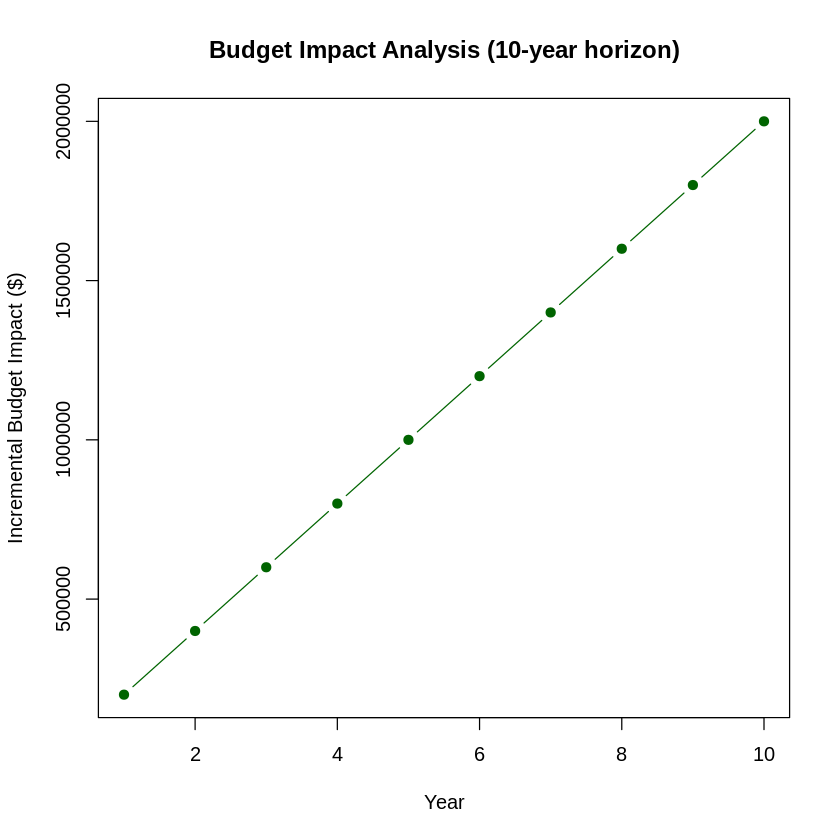

In [22]:
# Parameters
years <- 1:10
population <- 1000   # eligible patients each year
adoption <- pmin(seq(0.1, 1, length.out = 10), 1) # adoption curve (10% → 100%)

# Costs per patient
cost_standard <- 5000
cost_new <- 7000

# Total costs each year
treated_new <- population * adoption
treated_standard <- population - treated_new

cost_total_new <- treated_new * cost_new + treated_standard * cost_standard
cost_total_standard <- population * cost_standard

# Incremental budget impact
incremental <- cost_total_new - cost_total_standard

# Put into dataframe
bia_df <- data.frame(
  Year = years,
  Adoption = adoption,
  Cost_standard = cost_total_standard,
  Cost_with_new = cost_total_new,
  Incremental_cost = incremental
)

print(bia_df)

# Plot
plot(bia_df$Year, bia_df$Incremental_cost, type="b", pch=19,
     xlab="Year", ylab="Incremental Budget Impact ($)",
     main="Budget Impact Analysis (10-year horizon)",
     col="darkgreen")
abline(h=0, lty=2, col="grey")

## Section 8 — Survival & Health Outcomes Modeling

Cost-effectiveness models often need survival data:
- **Observed survival** from clinical trials (Kaplan–Meier curves).
- **Extrapolated survival** with parametric models (e.g. Weibull, Exponential).

We can estimate:
- **Life Years (LYs)** from area under the survival curve.
- **QALYs** by weighting survival by utility over time.

Mean survival (years):
 A: 13.40665 
 B: 19.98346 
QALY_A: 9.384655 
QALY_B: 15.98677 
Incremental QALY (B vs A): 6.602114 


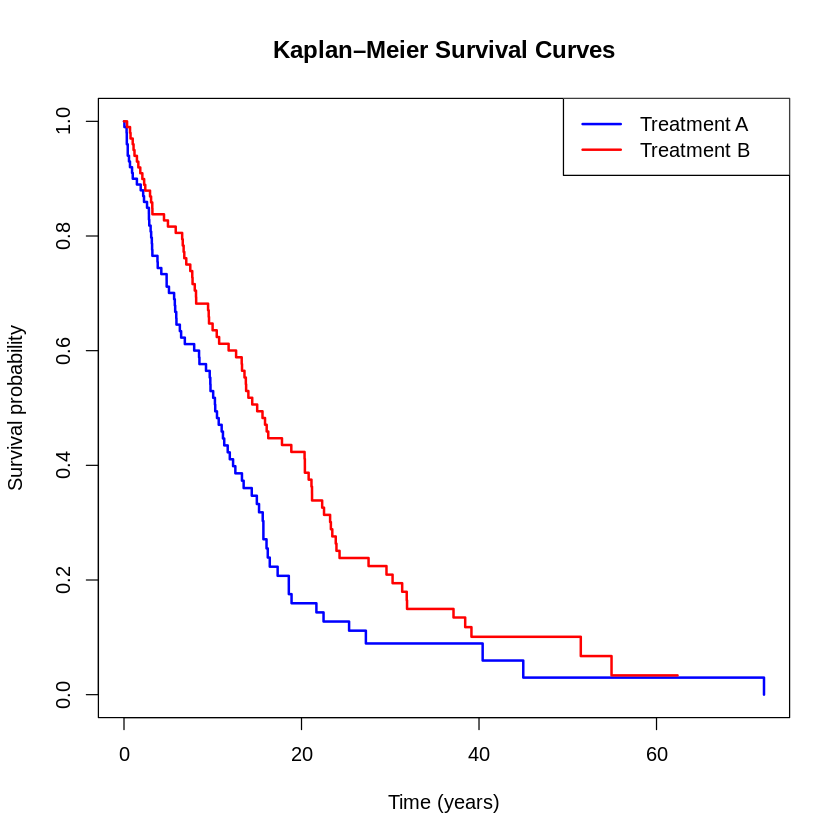

In [23]:
library(survival)

# Simulate example trial survival data
set.seed(123)
# Arm A: shorter survival
time_A <- rexp(100, rate=0.1)   # mean ~10 years
event_A <- rbinom(100, 1, 0.8)  # 80% observed
# Arm B: longer survival
time_B <- rexp(100, rate=0.07)  # mean ~14 years
event_B <- rbinom(100, 1, 0.8)

surv_data <- data.frame(
  time = c(time_A, time_B),
  status = c(event_A, event_B),
  arm = factor(c(rep("A",100), rep("B",100)))
)

# Kaplan–Meier survival curves
fit_km <- survfit(Surv(time, status) ~ arm, data=surv_data)

# Plot KM curves
plot(fit_km, col=c("blue","red"), lwd=2,
     xlab="Time (years)", ylab="Survival probability",
     main="Kaplan–Meier Survival Curves")
legend("topright", legend=c("Treatment A","Treatment B"),
       col=c("blue","red"), lwd=2)

# --- Parametric survival model: Exponential ---
fit_exp_A <- survreg(Surv(time, status) ~ 1, data=subset(surv_data, arm=="A"), dist="exponential")
fit_exp_B <- survreg(Surv(time, status) ~ 1, data=subset(surv_data, arm=="B"), dist="exponential")

# Mean survival (life years) = 1 / rate (exp model)
mean_surv_A <- 1 / (1/exp(coef(fit_exp_A)))
mean_surv_B <- 1 / (1/exp(coef(fit_exp_B)))

cat("Mean survival (years):\n A:", mean_surv_A, "\n B:", mean_surv_B, "\n")

# --- QALYs (with utility weights) ---
util_A <- 0.7
util_B <- 0.8

qaly_A <- mean_surv_A * util_A
qaly_B <- mean_surv_B * util_B

delta_qaly <- qaly_B - qaly_A

cat("QALY_A:", qaly_A, "\n")
cat("QALY_B:", qaly_B, "\n")
cat("Incremental QALY (B vs A):", delta_qaly, "\n")

## Section 9 — Discussion & Policy Interpretation

We have now covered the main analytic tools used in Health Economics:

1. **Cost-Effectiveness Basics (ICER & CE plane)**
   - Showed incremental costs and effects between 2 interventions.

2. **QALYs**
   - Combined life years × quality weights → more comprehensive than survival alone.

3. **Decision Trees**
   - Useful for short-term choices with discrete outcomes.

4. **Markov Models**
   - Suitable for chronic disease progression with recurring states.

5. **Probabilistic Sensitivity Analysis (PSA)**
   - Quantified uncertainty with CEAC curves and EVPI estimates.

6. **Budget Impact Analysis (BIA)**
   - Showed year-by-year affordability of new technologies.

7. **Survival & Health Outcomes**
   - Modeled trial data with KM and parametric approaches, translated into QALYs.

---

### Policy Implications

- **Cost-Effectiveness Threshold**: Decision makers compare ICERs to willingness-to-pay thresholds (e.g. $50,000/QALY).
- **Uncertainty**: CEAC shows probability of being cost-effective. High EVPI suggests more research is valuable.
- **Budget Impact**: Even if cost-effective, high budget impact may limit adoption.
- **Equity Considerations**: Economic models should complement, not replace, ethical and equity-based decisions.

---

### Key Takeaway

Economic evaluation provides **structured, evidence-based inputs** into health policy.
The final decision involves:
- Clinical effectiveness
- Cost-effectiveness
- Budget feasibility
- Ethical and social values